# I. Install and load libraries

In [ ]:
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import wandb 
import os
import logging
import warnings
warnings.filterwarnings('ignore')
from dotenv import load_dotenv
load_dotenv()

True

In [6]:
logging.basicConfig(level=logging.INFO,
                    format="%(asctime)s %(message)s",
                    datefmt='%d-%m-%Y %H:%M:%S')

logger = logging.getLogger()

# II. Downloading file from Wandb 

In [7]:
run = wandb.init(project="diabetes", job_type="preprocessing")

In [8]:
WANDB_API_KEY=os.environ.get('WANDB_API_KEY')
!wandb login --relogin $WANDB_API_KEY

wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\PC\_netrc
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


In [9]:
logger.info("Downloading and reading artifact")
artifact_X_train = wandb.use_artifact('diabetes/X_train_segregated.csv:latest', type='data_segregation')
artifact_X_val = wandb.use_artifact('diabetes/X_val_segregated.csv:latest', type='data_segregation')
artifact_X_test = wandb.use_artifact('diabetes/X_test_segregated.csv:latest', type='data_segregation')
artifact_y_train = wandb.use_artifact('diabetes/y_train_segregated.csv:latest', type='data_segregation')
artifact_y_val = wandb.use_artifact('diabetes/y_val_segregated.csv:latest', type='data_segregation')
artifact_y_test = wandb.use_artifact('diabetes/y_test_segregated.csv:latest', type='data_segregation')

X_train_dir = artifact_X_train.download()
X_val_dir = artifact_X_val.download()
X_test_dir = artifact_X_test.download()
y_train_dir = artifact_y_train.download()
y_val_dir = artifact_y_val.download()
y_test_dir = artifact_y_test.download()

X_train_path = os.path.join(X_train_dir, "X_train.csv")
X_val_path = os.path.join(X_val_dir, "X_val.csv")
X_test_path = os.path.join(X_test_dir, "X_test.csv")
y_train_path = os.path.join(y_train_dir, "y_train.csv")
y_val_path = os.path.join(y_val_dir, "y_val.csv")
y_test_path = os.path.join(y_test_dir, "y_test.csv")

X_train = pd.read_csv(X_train_path)
X_val = pd.read_csv(X_val_path)
X_test = pd.read_csv(X_test_path)

y_train = pd.read_csv(y_train_path)
y_val = pd.read_csv(y_val_path)
y_test = pd.read_csv(y_test_path)

06-05-2025 11:23:41 Downloading and reading artifact
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


# III. Preprocessing

## 1. Missing Values Detection

In [10]:
logger.info("Mising values detection")
def detect_missing_values(df):
    missing_count = df.isnull().sum()
    missing_percent = (missing_count / len(df)) * 100
    missing_summary = pd.DataFrame({
        'Missing Count': missing_count,
        'Missing %': missing_percent
    })
    return missing_summary[missing_summary['Missing Count'] > 0].sort_values(by='Missing Count', ascending=False)

06-05-2025 11:24:11 Mising values detection


In [11]:
print(detect_missing_values(X_train))
print(detect_missing_values(X_val))
print(detect_missing_values(X_test))

Empty DataFrame
Columns: [Missing Count, Missing %]
Index: []
Empty DataFrame
Columns: [Missing Count, Missing %]
Index: []
Empty DataFrame
Columns: [Missing Count, Missing %]
Index: []


## 3. Outliers Clipping

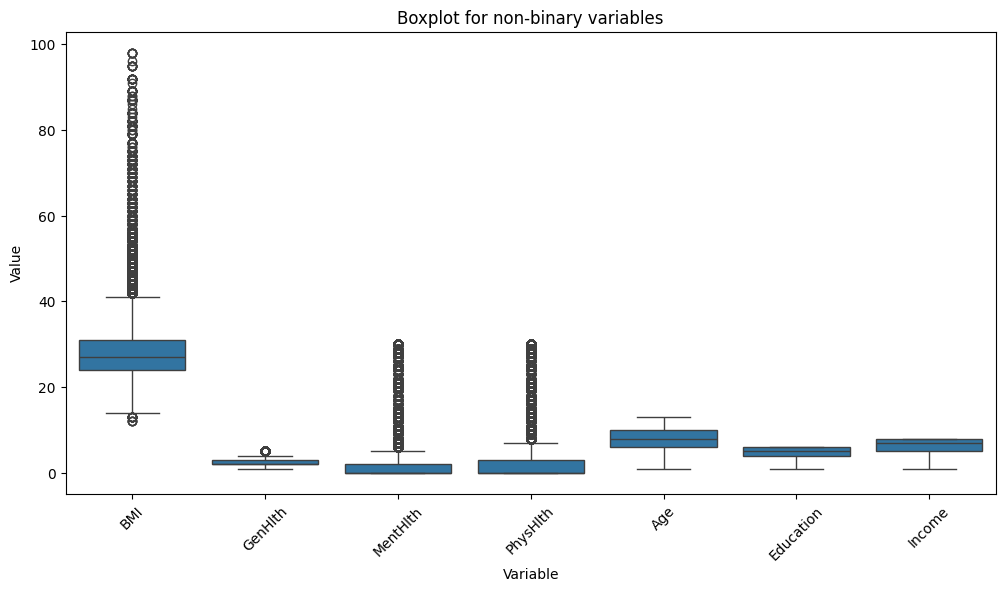

In [12]:
non_binary_columns = [col for col in X_train.columns if X_train[col].nunique() > 2]

df_long = X_train[non_binary_columns].melt(var_name='Variable', value_name='Value')

plt.figure(figsize=(12, 6))
sns.boxplot(x='Variable', y='Value', data=df_long)
plt.xticks(rotation=45)
plt.title('Boxplot for non-binary variables')
plt.show()

From what i can see, there are a lot of outliers in columns BMI, PhysHlth, MenHlth, GenHlth. From this moment, we approach this problem with our most common method, which is clipping

In [13]:
logger.info("Outlier Clipping")
q1 = X_train[['BMI', 'PhysHlth', 'MentHlth', 'GenHlth']].quantile(0.25)
q3 = X_train[['BMI', 'PhysHlth', 'MentHlth', 'GenHlth']].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

for col in ['BMI', 'PhysHlth', 'MentHlth', 'GenHlth']:
    X_train[col] = X_train[col].clip(lower=lower_bound[col], upper=upper_bound[col])  
    X_val[col] = X_val[col].clip(lower=lower_bound[col], upper=upper_bound[col])            
    X_test[col] = X_test[col].clip(lower=lower_bound[col], upper=upper_bound[col])

06-05-2025 11:24:14 Outlier Clipping


In [14]:
df_long = X_train[non_binary_columns].melt(var_name='Variable', value_name='Value')

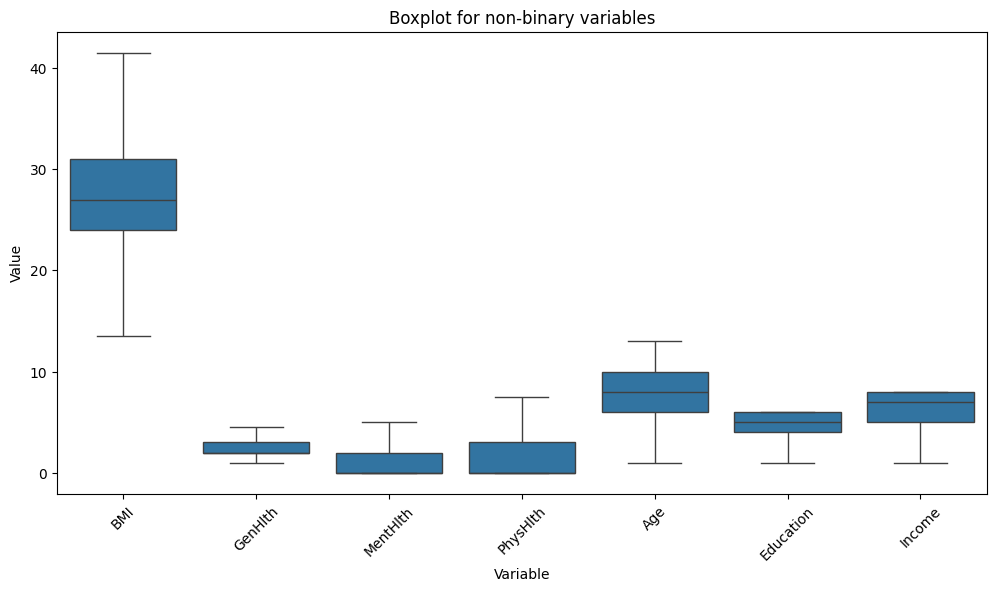

In [15]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='Variable', y='Value', data=df_long)
plt.xticks(rotation=45)
plt.title('Boxplot for non-binary variables')
plt.show()

# IV. Uploading file to Wandb 

In [16]:
logger.info("Uploading preprocessed train test dataset")
X_train_file = os.path.join(X_train_dir, "X_train.csv")
X_test_file = os.path.join(X_test_dir, "X_test.csv")
X_val_file = os.path.join(X_val_dir, "X_val.csv")
y_train_file = os.path.join(y_train_dir, "y_train.csv")
y_test_file = os.path.join(y_test_dir, "y_test.csv")
y_val_file = os.path.join(y_val_dir, "y_val.csv")

X_train.to_csv(X_train_file, index=False)
X_val.to_csv(X_val_file, index=False)
X_test.to_csv(X_test_file, index=False)
y_train.to_csv(y_train_file, index=False)
y_val.to_csv(y_val_file, index=False)
y_test.to_csv(y_test_file, index=False)

06-05-2025 11:24:18 Uploading preprocessed train test dataset


In [17]:
run = wandb.init(project="diabetes", job_type="preprocessing")

In [18]:
def upload_artifact(artifact_name, file_path, artifact_type="preprocessing", artifact_description="Preprocessed data"):
    artifact = wandb.Artifact(
        name=artifact_name, 
        type=artifact_type,
        description=artifact_description
    )
    artifact.add_file(file_path)  
    wandb.log_artifact(artifact)

In [19]:
upload_artifact("X_train.csv", X_train_file)
upload_artifact("X_test.csv", X_test_file)
upload_artifact("X_val.csv", X_val_file)
upload_artifact("y_train.csv", y_train_file)
upload_artifact("y_test.csv", y_test_file)
upload_artifact("y_val.csv", y_val_file)

In [20]:
wandb.finish()